In [1]:
# General comments when using this skyfield package:
#
#- baricentric: barycentric = earth.at(t) or dws.at(t)
#  position of earth center or dws or any other point in space measured from the Solar System’s center of mass (without any corrections)
#- astrometric = barycentric.observe(sun)
#  when you use astrometric you can observe moon from earth center or dws at time t,
#  it applies the effect of light travel time.
#  i.e, on Earth we see the Moon where it was about 1.3 seconds ago, the Sun where it was 8 minutes ago.
#  Recently, it has been confirmed that "gravity" (according to Einstein) travel at the speed of light,
#  so if the sun "disappears" we will still feel gravity as waves arriving during 8 minutes, read:
#  https://www.forbes.com/sites/startswithabang/2020/12/18/ask-ethan-why-doesnt-gravity-happen-instantly/?sh=343391f17fd2
#- apparent = astrometric.apparent()
#  correct aberration of light produced by the observer’s own motion through space, and the gravitational deflection
#  light that passes close to masses like the Sun and Jupiter — and, for an observer on the Earth’s surface, for deflection produced by the Earth’s own gravity.
#  These corrections seem to be important when looking into the space to find an object, but not
#  for the gravitational effects on tides; however, the only way to get azimuth and altitude in this package is using .apparent()
#- altitude,azimuth = apparent.altaz()
#  get altitude and azimuth, can only be called with .apparent()

#Tutorials:
#https://rhodesmill.org/skyfield/positions.html#quick-reference
#
#https://rhodesmill.org/skyfield/time.html#downloading-timescale-files
#https://rhodesmill.org/skyfield/api-time.html#calendar-date
#https://rhodesmill.org/skyfield/example-plots.html
#https://rhodesmill.org/skyfield/positions.html
#https://rhodesmill.org/skyfield/

from skyfield.api import load
from skyfield.api import N, S, W, E, wgs84
import numpy as np
import matplotlib.pyplot as plt
import glob
import xarray as xr
import dask as da
import pandas as pd
import scipy.fftpack as fftt #just for checking peaks of signals
import datetime 

In [2]:
#Average and std every M2----
#
#Conclusion 
#Using data every integer M2=44714s, or average-M2, or starting from different initial time: 
# - induce a long term lag in the 36-years data of 1.3h in comparison with the more accurate M2 (44714.16432s) that dont.
# - the effect of the appox integer M2 on the angular positions and distance depends when you start and on the avg.
# - it is supposed this is a real effect in our simulation, as we deployed particles every integer M2.
#Data to be used:
# - mean and std of position and distances, as well as the initial values at the begin of the interval


In [3]:
#----------
home_dir="/export/lv4/user/jfajardourbina/"
ml_dir=f"{home_dir}dws_ulf_getm_2D_depth_avg/experiments_post_proc/lagrangian_simulation_36years/machine_learning_github/Lagrangian_ML/"
dir_displacement="net_displacement/"
#
m2=int(12.42*3600+2) #period in seconds
dt_fac_m2_sec=283*2 #get astronomical data every 566s = 9.43 min (factor of m2=44714)
#
#paths for output data
dir_post_proc_data=f"{ml_dir}post_proc_data/" #to save wind interp files
dir_tides="tides_skyfield/"
file_tides="skyfield_distance_azimuth_altitude_avg_std_M2_for_convlstm.nc"

In [4]:
#get time from net displacement files---
files_displacement=sorted(glob.glob(f'{dir_post_proc_data}{dir_displacement}*.nc',recursive=True))
#concat all the files
dsdis=xr.open_mfdataset(files_displacement,concat_dim="time",combine='nested',parallel='True',chunks={'time': -1},
                        decode_cf=True, decode_times=True)
time_dis=dsdis.time.values
dsdis.close(); del dsdis
#
nt_dis=len(time_dis) #=25290 deployments
#
#times to get astronomical info and then perform std and avg in the m2 interval---
tini=time_dis[0]; tinip=pd.to_datetime(tini)
tend=time_dis[-1]+np.timedelta64(m2-dt_fac_m2_sec,'s'); tendp=pd.to_datetime(tend) #1 extra m2 to have the full interval for the last deployment but without the last point
dt=dt_fac_m2_sec/86400 #dt_fac_m2_sec = 566s = 9.43 min (factor of m2=44714)
print("deployments = ",nt_dis)

deployments =  25290


In [5]:
#Create a skyfield timescale---
ts = load.timescale()

In [6]:
#Load the JPL ephemeris DE421 (covers 1900-2050)---
#An ephemeris from the JPL provides Sun, Moon, planets and Earth positions.
eph = load('de421.bsp')
earth, moon, sun = eph['earth'], eph['moon'], eph['sun']

In [7]:
#create a time vector with skyfield--- 

#find total seconds between init and final date:
ti=datetime.datetime(tinip.year,tinip.month,tinip.day,tinip.hour,tinip.minute,tinip.second)
te=datetime.datetime(tendp.year,tendp.month,tendp.day,tendp.hour,tendp.minute,tendp.second)
tot_sec=(te-ti).total_seconds() #total elapsed seconds
#
#build Time objects from an UTC calendar date, using the init UTC date and the elapsed seconds since this initial date
times=ts.utc(tinip.year,tinip.month,tinip.day,tinip.hour,tinip.minute,np.arange(tinip.second,tot_sec+1e-5,dt_fac_m2_sec))
dtt=np.diff(times.tt) #=dt=9.43min
print(dt_fac_m2_sec,dtt.min()*86400,dtt.mean()*86400,dtt.max()*86400,times.shape)
#
#check the first 2 and the last 2 times of the vector built with skynet
#there are 17 leap seconds from 1980-2015 (for us and accord to wikipedia), but it does not matter since after referencing the first date, then it is only used the elapsed time
#we have the same time difference (elapsed time in seconds) for:
# - tot_sec = dt_fac_m2_sec*(len(times)-1) = the actual elapsed seconds
# - times[-1].tt-times[0].tt)*86400
# - np.sum(np.diff(times.tt))*86400
# - and also assuming that the init and final dates are in a TT calendar (which is not ok since they are in a UTC calendar)
print(tinip,times[[0,1]].utc_strftime('%Y-%m-%d %H:%M:%S'))
print(tendp,times[[-2,-1]].utc_strftime('%Y-%m-%d %H:%M:%S'))
np.sum(np.diff(times.tt))*86400,(times[-1].tt-times[0].tt)*86400,tot_sec,dt_fac_m2_sec*(len(times)-1)

566 565.9999877214432 565.9999999999953 566.0000279545784 (1997910,)
1980-01-01 08:20:00 ['1980-01-01 08:20:00', '1980-01-01 08:29:26']
2015-11-01 12:01:34 ['2015-11-01 11:51:51', '2015-11-01 12:01:17']


(1130816493.999991, 1130816493.999991, 1130816494.0, 1130816494)

In [8]:
#This is not ok, because we are feeding ts.tt with our utc calendar dates,
#ts.tt requires as input TT calendar dates, which we dont have,
#However, the elapsed time is the same as above
#
times2=ts.tt(tinip.year,tinip.month,tinip.day,tinip.hour,tinip.minute,np.arange(tinip.second,tot_sec+1e-5,dt_fac_m2_sec))
dtt2=np.diff(times2.tt) #=dt=9.43min
print(dt_fac_m2_sec,dtt2.min()*86400,dtt2.mean()*86400,dtt2.max()*86400,times2.shape)
print(tinip,times2[[0,1]].tt_strftime('%Y-%m-%d %H:%M:%S'))
print(tendp,times2[[-2,-1]].tt_strftime('%Y-%m-%d %H:%M:%S'))
np.sum(np.diff(times2.tt))*86400,(times2[-1].tt-times2[0].tt)*86400,tot_sec,dt_fac_m2_sec*(len(times2)-1)

566 565.9999877214432 566.0000000000156 566.0000279545784 (1997910,)
1980-01-01 08:20:00 ['1980-01-01 08:20:00', '1980-01-01 08:29:26']
2015-11-01 12:01:34 ['2015-11-01 11:52:08', '2015-11-01 12:01:34']


(1130816494.000031, 1130816494.000031, 1130816494.0, 1130816494)

In [9]:
# #the same as above but a bit more confusing because we also have to use ts.tt_jd() instead of only ts.utc()

# #first build initial and final Time objects from an UTC calendar date (our data is in UTC)
# tinis=ts.utc(tinip.year,tinip.month,tinip.day,tinip.hour,tinip.minute,tinip.second)
# tends=ts.utc(tendp.year,tendp.month,tendp.day,tendp.hour,tendp.minute,tendp.second)
# #now build all Times
# #.tt_jd(): builds Time objects from Terrestrial Time TT Julian dates, so use .tt from above dates 
# times=ts.tt_jd(np.arange(tinis.tt*86400,tends.tt*86400+1e-5,dt_fac_m2_sec)/86400) 
# #times=ts.tt_jd(np.arange(tinis.tt,tends.tt+1e-5,dt)) #if we use this due to rounding issues of dt we will not have the correct elapsed time
# dtt=np.diff(times.tt) #=dt=9.43min
# print(dt_fac_m2_sec,dtt.min()*86400,dtt.mean()*86400,dtt.max()*86400,times.shape)

# #check the first 2 and the last 2 times of the vector built with skynet
# #there are 17 leap seconds from 1980-2015 (for us and accord to wikipedia), but it does not matter since after referencing the first date, then it is only used the elapsed time
# #we have the same time difference (elapsed time in seconds) for:
# # - dt_fac_m2_sec*(len(times)-1) = the actual elapsed seconds
# # - times[-1].tt-times[0].tt)*86400
# # - np.sum(np.diff(times.tt))*86400
# # - and also assuming that the init and final dates are in a TT calendar (which is not ok since they are in a UTC calendar)
# print(tinip,tinis.utc_strftime('%Y-%m-%d %H:%M:%S'),times[[0,1]].utc_strftime('%Y-%m-%d %H:%M:%S'))
# print(tendp,tends.utc_strftime('%Y-%m-%d %H:%M:%S'),times[[-2,-1]].utc_strftime('%Y-%m-%d %H:%M:%S'))
# print(np.sum(np.diff(times.tt))*86400,(times[-1].tt-times[0].tt)*86400,(tends.tt-tinis.tt)*86400,dt_fac_m2_sec*(len(times)-1))
# print()

# #This is not ok, because we are feeding ts.tt with our utc calendar dates,
# #ts.tt requires as input TT calendar dates, which we dont have,
# #However, the elapsed time is the same as above

# t1=ts.tt(tinip.year,tinip.month,tinip.day,tinip.hour,tinip.minute,tinip.second)
# t2=ts.tt(tendp.year,tendp.month,tendp.day,tendp.hour,tendp.minute,tendp.second)
# times2=ts.tt_jd(np.arange(t1.tt*86400,t2.tt*86400+1,dt_fac_m2_sec)/86400) 
# dtt=np.diff(times2.tt) #=dt=9.43min
# print(dt_fac_m2_sec,dtt.min()*86400,dtt.mean()*86400,dtt.max()*86400,times2.shape)
# print(tinip,times2[[0,1]].tt_strftime('%Y-%m-%d %H:%M:%S'))
# print(tendp,times2[[-2,-1]].tt_strftime('%Y-%m-%d %H:%M:%S'))
# print(np.sum(np.diff(times2.tt))*86400,(times2[-1].tt-times2[0].tt)*86400,(t2.tt-t1.tt)*86400,dt_fac_m2_sec*(len(times2)-1))

In [9]:
#convert to datetime using utc_datetime skyfield function
times_datetime=times.utc_datetime()
print(times_datetime,times_datetime.shape)
print()

#using numpy (it does not take into account leap seconds), but the size of the array is the same as skyfield
#the elapsed time is also the same
times_np=np.arange(tini,tend+np.timedelta64(1,'s'),dt_fac_m2_sec,dtype='datetime64[s]') 
print(times_np,times_np.shape)

[datetime.datetime(1980, 1, 1, 8, 20, tzinfo=datetime.timezone.utc)
 datetime.datetime(1980, 1, 1, 8, 29, 26, tzinfo=datetime.timezone.utc)
 datetime.datetime(1980, 1, 1, 8, 38, 52, tzinfo=datetime.timezone.utc)
 ...
 datetime.datetime(2015, 11, 1, 11, 42, 25, tzinfo=datetime.timezone.utc)
 datetime.datetime(2015, 11, 1, 11, 51, 51, tzinfo=datetime.timezone.utc)
 datetime.datetime(2015, 11, 1, 12, 1, 17, tzinfo=datetime.timezone.utc)] (1997910,)

['1980-01-01T08:20:00' '1980-01-01T08:29:26' '1980-01-01T08:38:52' ...
 '2015-11-01T11:42:42' '2015-11-01T11:52:08' '2015-11-01T12:01:34'] (1997910,)


In [10]:
#check time dimensions
nt_interval=int(m2/dt_fac_m2_sec) #points in the m2 interval (right border of interval open)
nt_dep=len(times_np)//nt_interval #=len(t_dep), final shape after mean or std in the m2 interval. 
nt_interval,nt_dep,nt_dis,nt_interval*nt_dep

(79, 25290, 25290, 1997910)

In [11]:
#Computations in Topocentric coordinates-----
#
#specific to your location on the Earth’s surface
lat=53.0; lon=4.5 #in front of Texel
dws = earth + wgs84.latlon(lat*N,lon*E) 

### Sun

In [12]:
%%time
#SUN----
#3.5minutes from 1980-2016
astro_sun = dws.at(times).observe(sun)
#- altitude or elevation (deg,min,sec): -90:90deg
#- azimuth (deg,min,sec): 0:360deg
#- distance (au or km): 1au (astronomical unit) = 1.496e8km
alt_sun, az_sun, dist_sun = astro_sun.apparent().altaz()
print(alt_sun)
print(az_sun)
#print(dist_sun)
#
#convert above values to arrays---
#altitude_sun_rad=alt_sun.radians
altitude_sun_deg=alt_sun.degrees
#azimuth_sun_rad=alt_sun.radians
azimuth_sun_deg=az_sun.degrees
distance_sun_au = dist_sun.au #AU units
#distance_sun_km = dist_sun.km #km units
#distance_sun_km2 = dist_sun2.km #km units
#a=distance_sun_km-distance_sun_km2 #almost the same distnace when using .radec
print(altitude_sun_deg[[0,-1]])
print(azimuth_sun_deg[[0,-1]])
print(distance_sun_au[[0,-1]])
#print(distance_sun_km[[0,-1]])

1997910 values from 01deg 54' 53.1" to 22deg 08' 58.2"
1997910 values from 134deg 04' 23.5" to 189deg 20' 09.3"
[ 1.9147423  22.14950607]
[134.07320716 189.33591968]
[0.98327023 0.99253671]
CPU times: user 5min 47s, sys: 32.1 s, total: 6min 19s
Wall time: 3min 21s


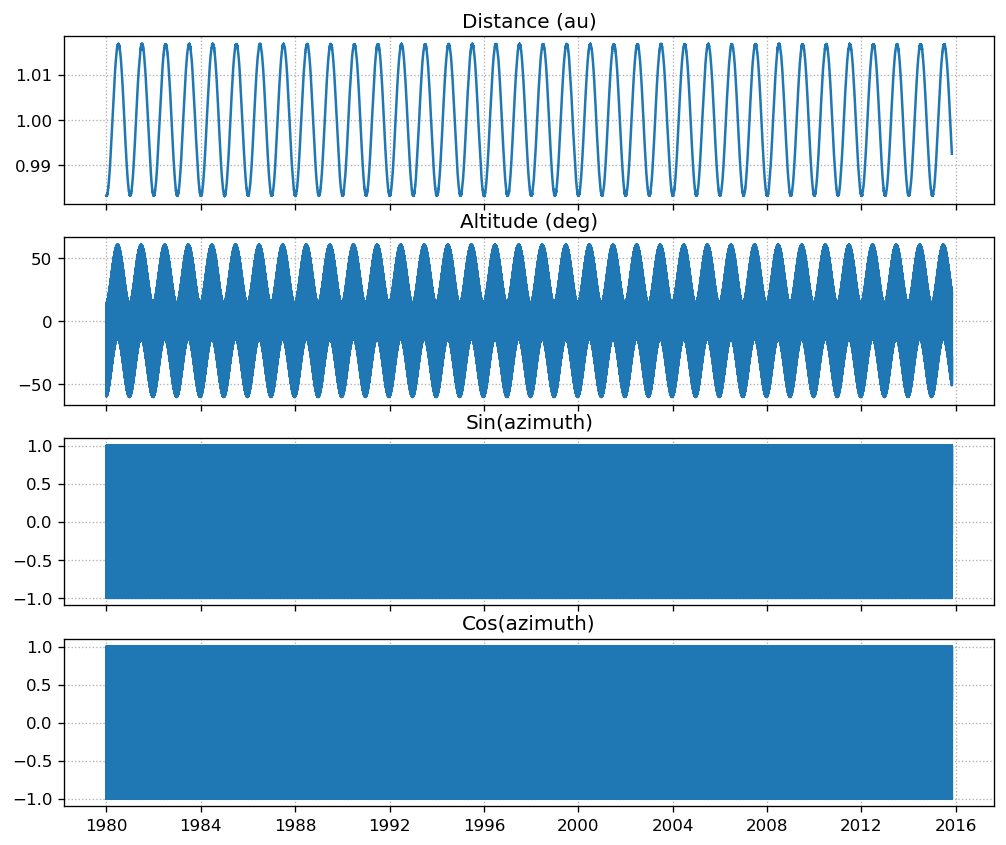

In [13]:
#
#https://en.wikipedia.org/wiki/Lunar_precession
#
fig,ax=plt.subplots(4,1,figsize=(10,8.5),dpi=120)
#
#Distance (perigee-apogee variation):
# moon at perigge aprox 356500 km = 0.002383au
# moon at apogee approx 406700 km = 0.0027186au
# so diff = 50200 km (14% of perigee)
#- 8.85y (0.000035au): Apsidal precession, rotation of moon orbit around earth
#- 205.89days approx 7 synodic months (0.0001au, mainly perigee):
#  mainly affects the perigee, due to the sun distortion of the moon path.
#  It seems that the reduction of perigee distance is related to the anomalistic month,
#  and it is enhanced when the moon is new or full. This is the reason why we have super moons.
#  If the earth and moon were the only bodies that mattered, the eccentricity would be constant.
#  But in fact the sun is also pulling on the moon, which gives this additional 7-month distance variations.
#- 27.55d anomalistic month (0.0003au)
#- 1day (0.00005au) = 6371*2/(1.496e8)*np.cos(lat/180*np.pi)
#  due to rotation of eart distance to the moon from a point on earth surface varies.
ax[0].plot(times_np,distance_sun_au)
ax[0].grid(ls=":");ax[0].set_title("Distance (au)");ax[0].set_xticklabels("");
#
#Altitude:
# 0 altitude when the moon is on the horizont.
#- 18.61y (10deg amp): nodal precession, i.e., rotation of the ascending node (intersection of moon orbit with ecliptic from below to above ecliptic)
#  This is related to changes in total altitude with respect to equator (declination)
#  in this interval of time moon could be between 5deg above or 5deg below eclipctic, therefore moon can reach
#  max declination 28.5 or min -28.5 (when the moon is above ecliptic (5deg) and earth below it(23.5), or visceversa)
#  max 18.5 or min -18.5 (when the moon is above ecliptic and earth also above it, or visceversa)
#- 27.21d draconic or nodal month: moon can go from -28.5:28.5 or -18.5:18.5 (with respect to eclipctic) due to moon orbit
#- 1day(75deg = 2*(90-lat=53) range), related to lunar day.
#So, taking into account that we are in 53N, max min values of altitude:
#    for lunar "summer" 90-[53-28.5]=65.5       (or 55.5 with 18.5)
#    for lunar "winter" -[90-[53-28.5]]=-65.5   (or -55.5 with 18.5)
ax[1].plot(times_np,altitude_sun_deg)
ax[1].grid(ls=":");ax[1].set_title("Altitude (deg)");ax[1].set_xticklabels("");
#
#Azimuth:
#  needs cos and sin since ang[0-360] is discontinuous
#- 1 draconic or nodal month: every 13.5day the shape of the azimuth function change because
#  the day based on the moon 24.84d (like the solar day of 24h) last longer than the night when we are in  moon "summer" (high altitudes)
#  this creates a lag after 1 period with respect to 24h (like M2 tide)
#- 1day
ax[2].plot(times_np,np.sin(azimuth_sun_deg/180*np.pi))
ax[2].grid(ls=":");ax[2].set_title("Sin(azimuth)");ax[2].set_xticklabels("");
ax[3].plot(times_np,np.cos(azimuth_sun_deg/180*np.pi))
ax[3].grid(ls=":");ax[3].set_title("Cos(azimuth)");


(3652.0, 3666.0)

/export/lv4/user/jfajardourbina/programs/miniconda3/envs/phd_parcelsv230/lib/python3.8/site-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


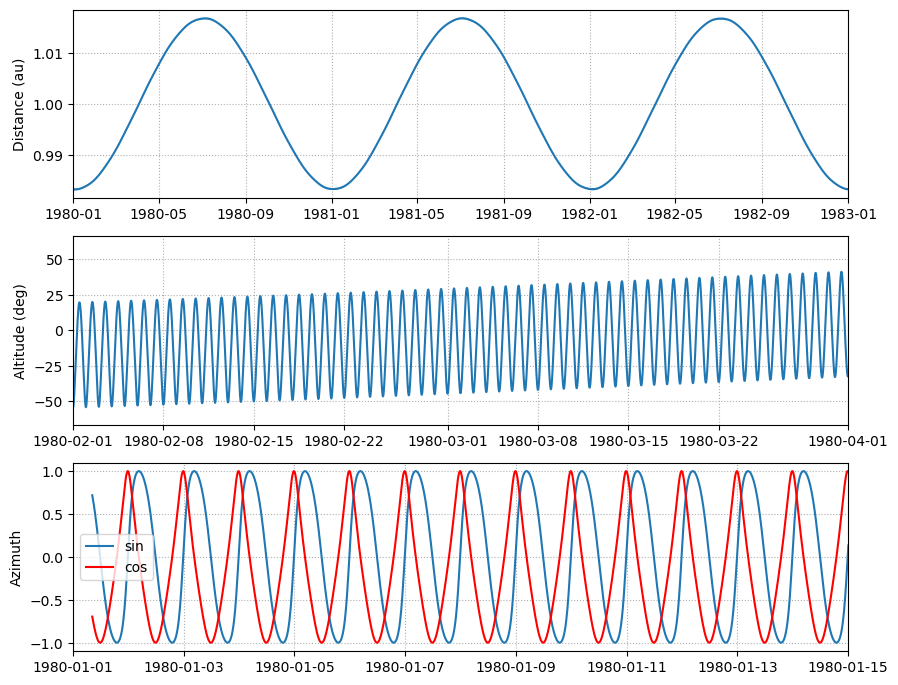

In [14]:
fig,ax=plt.subplots(3,1,figsize=(10,8.5),dpi=100)
#
ax[0].plot(times_np,distance_sun_au)  
ax[0].grid(ls=":");ax[0].set_ylabel("Distance (au)")
ax[0].set_xlim(np.datetime64("1980-01-01"),np.datetime64("1983-01-01"))
#
ax[1].plot(times_np,altitude_sun_deg)  
ax[1].grid(ls=":");ax[1].set_ylabel("Altitude (deg)")
ax[1].set_xlim(np.datetime64("1980-02-01"),np.datetime64("1980-04-01"))
#
#ax[2].plot(times_np,azimuth_sun_deg/360*24) 
ax[2].plot(times_np,np.sin(azimuth_sun_deg/180*np.pi),label="sin")  
ax[2].grid(ls=":");ax[2].set_ylabel("Azimuth")
ax[2].plot(times_np,np.cos(azimuth_sun_deg/180*np.pi),c='r',label="cos")   
ax[2].legend()
ax[2].set_xlim(np.datetime64("1980-01-01"),np.datetime64("1980-01-15"))

In [67]:
#FFT---

In [15]:
n=len(times);  #1/24 days
freq=fftt.fftfreq(n, dt)[1:n//2+1]
#freq2 =np.arange(n//2+1)[1:]/(n*dtt) #the same as above
per=1/freq

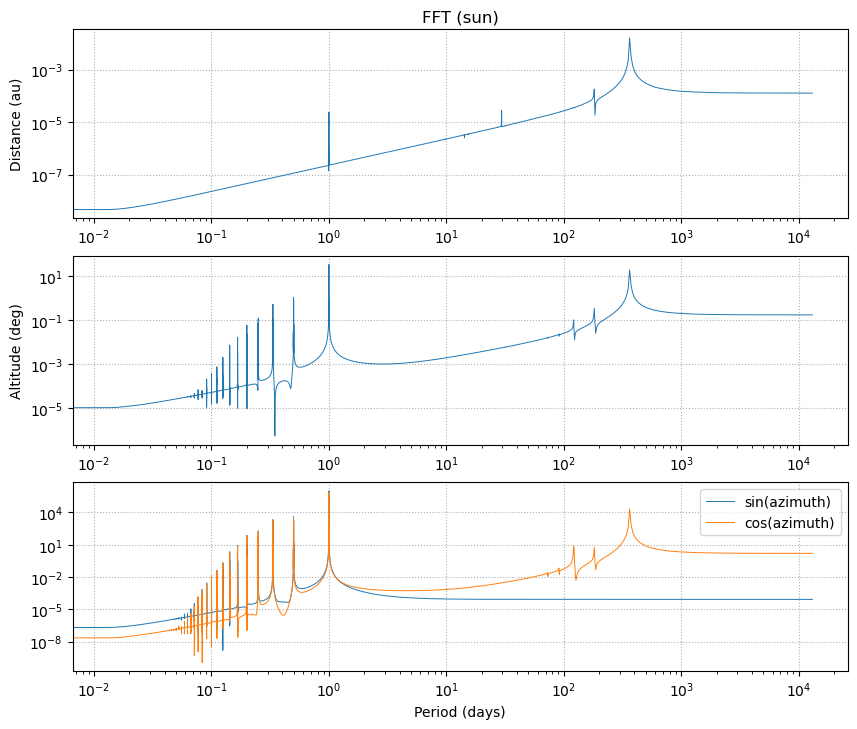

In [16]:
fig,ax=plt.subplots(3,1,figsize=(10,8.5),dpi=100)
yf=(np.abs(fftt.fft(distance_sun_au))[:n//2+1]/n)[1:] #here we are selecting half the spectra from high freq to low only, and excluding first coefficient =avg
ax[0].loglog(1/freq,2*yf,'-',ms=2,lw=.7);ax[0].grid(ls=":");ax[0].set_ylabel("Distance (au)");ax[0].set_title("FFT (sun)")
yf=(np.abs(fftt.fft(altitude_sun_deg))[:n//2+1]/n)[1:]
ax[1].loglog(1/freq,2*yf,'-',ms=2,lw=.7);ax[1].grid(ls=":");ax[1].set_ylabel("Altitude (deg)")
yf=(np.abs(fftt.fft(np.sin(azimuth_sun_deg/180*np.pi)))[:n//2+1]**2/n)[1:]
ax[2].loglog(1/freq,2*yf,'-',ms=2,lw=.7,label="sin(azimuth)");ax[2].grid(ls=":");ax[2].set_xlabel("Period (days)");
yf=(np.abs(fftt.fft(np.cos(azimuth_sun_deg/180*np.pi)))[:n//2+1]**2/n)[1:]
ax[2].loglog(1/freq,2*yf,'-',ms=2,lw=.7,label="cos(azimuth)");ax[2].grid(ls=":");ax[2].set_xlabel("Period (days)");
ax[2].legend()

In [18]:
## circular mean and std of angles (without taking into account the magnitude of vector)
##https://en.wikipedia.org/wiki/Directional_statistics#The_fundamental_difference_between_linear_and_circular_statistics

def circ_mean_std(var,units="deg",axis=-1):
    
    if units=="deg":
        fac=np.pi/180.
    else:
        fac=1.
    var=var*fac
    
    #mean
    sin_mean = np.mean(np.sin(var),axis=axis); cos_mean = np.mean(np.cos(var),axis=axis)
    var_mean = np.arctan2(sin_mean,cos_mean) #=np.arctan2(y,x), y/x=tan(angle)
    #if type(var).__name__  == "ndarray": print("this is an array")
    
    #std
    var_std=np.minimum(1.,sin_mean**2+cos_mean**2) #to avoid round issues
    var_std=(-np.log(var_std))**.5
    
    if units=="deg":
        var_mean/=fac; var_std/=fac
    
    return var_mean, var_std

#and check with scipy
from scipy.stats import circmean,circstd

In [19]:
#reshape variables---
#(nt_dep,nt_interval)
distance_sun_au_re=np.reshape(distance_sun_au,(nt_dep,nt_interval))
altitude_sun_deg_re=np.reshape(altitude_sun_deg,(nt_dep,nt_interval))
azimuth_sun_deg_re=np.reshape(azimuth_sun_deg,(nt_dep,nt_interval))

In [20]:
mean_distance_sun_au, std_distance_sun_au = np.mean(distance_sun_au_re,axis=-1), np.std(distance_sun_au_re,axis=-1)
mean_altitude_sun_deg, std_altitude_sun_deg = circ_mean_std(altitude_sun_deg_re)
mean_azimuth_sun_deg, std_azimuth_sun_deg = circ_mean_std(azimuth_sun_deg_re)
#
#the same as above using scipy:
# mean_altitude_sun_deg2, std_altitude_sun_deg2 = circmean(altitude_sun_deg_re*np.pi/180,axis=-1),circstd(altitude_sun_deg_re*np.pi/180,axis=-1)
# mean_altitude_sun_deg2*=180/np.pi; std_altitude_sun_deg2*=180/np.pi
# a=mean_altitude_sun_deg-mean_altitude_sun_deg2
# b=std_altitude_sun_deg-std_altitude_sun_deg2
# a.min(),a.max(),b.min(),b.max()

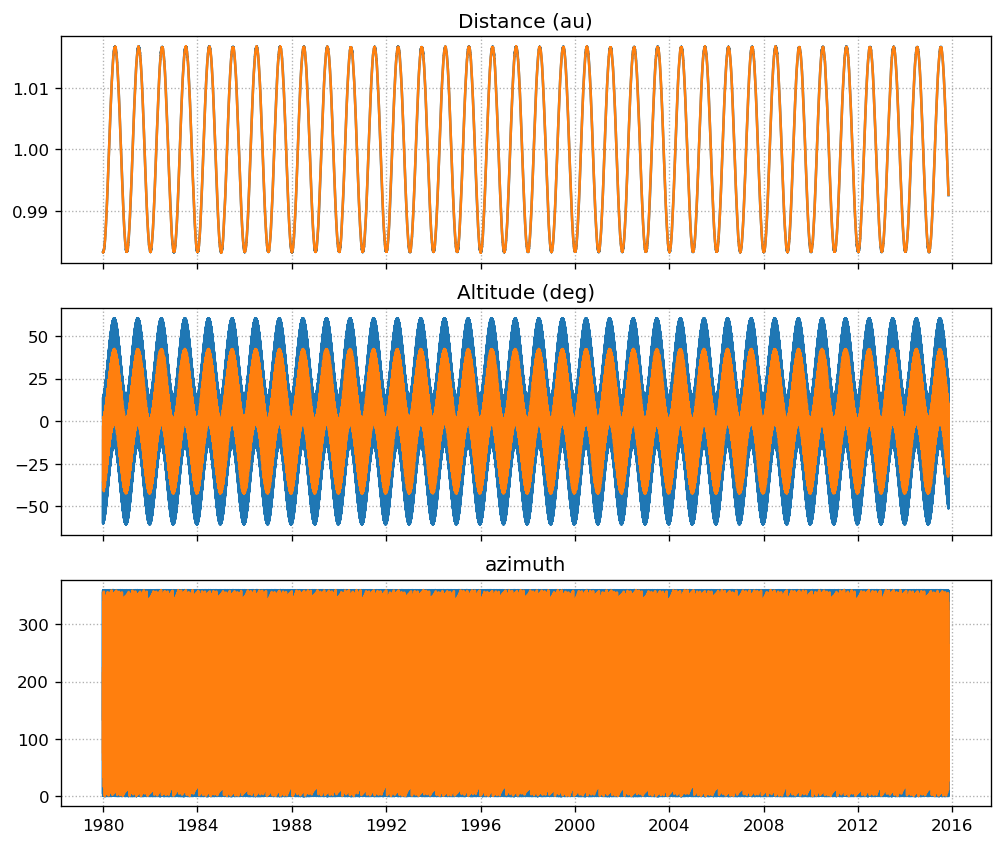

In [21]:
fig,ax=plt.subplots(3,1,figsize=(10,8.5),dpi=120)
#Distance (perigee-apogee variation):
ax[0].plot(times_np,distance_sun_au)
ax[0].plot(time_dis+np.timedelta64(m2//2,"s"),mean_distance_sun_au)
ax[0].grid(ls=":");ax[0].set_title("Distance (au)");ax[0].set_xticklabels("");
#ax[0].set_xlim(np.datetime64("1980-01-01"),np.datetime64("1996-01-01"))
#Altitude:
ax[1].plot(times_np,altitude_sun_deg)
ax[1].plot(time_dis+np.timedelta64(m2//2,"s"),mean_altitude_sun_deg)
ax[1].grid(ls=":");ax[1].set_title("Altitude (deg)");ax[1].set_xticklabels("");
#ax[1].set_xlim(np.datetime64("1980-01-01"),np.datetime64("1996-01-01"))
#Azimuth:
#convert azimuth from -180:180
#azimuth_sun_deg2=azimuth_sun_deg*1.
#azimuth_sun_deg2[azimuth_sun_deg2>180]=azimuth_sun_deg2[azimuth_sun_deg2>180]-360
#ax[2].plot(times_np,azimuth_sun_deg2)
#ax[2].plot(times_np[nt_interval:nt_interval*2],azimuth_sun_deg2[nt_interval:nt_interval*2],"-o",ms=2)
#ax[2].plot(time_dis+np.timedelta64(m2//2,"s"),azimuth_sun_deg2,"-o")
#
#convert azimuth from 0:360
mean_azimuth_sun_deg2=mean_azimuth_sun_deg*1.
mean_azimuth_sun_deg2[mean_azimuth_sun_deg2<0]=mean_azimuth_sun_deg2[mean_azimuth_sun_deg2<0]+360
ax[2].plot(times_np,azimuth_sun_deg)
ax[2].plot(time_dis+np.timedelta64(m2//2,"s"),mean_azimuth_sun_deg2)
ax[2].grid(ls=":");ax[2].set_title("azimuth");
#ax[2].set_xlim(np.datetime64("1980-01-01"),np.datetime64("1996-01-01"));
#ax[3].plot(times_np,np.cos(azimuth_sun_deg/180*np.pi))
#ax[3].grid(ls=":");ax[3].set_title("Cos(azimuth)");

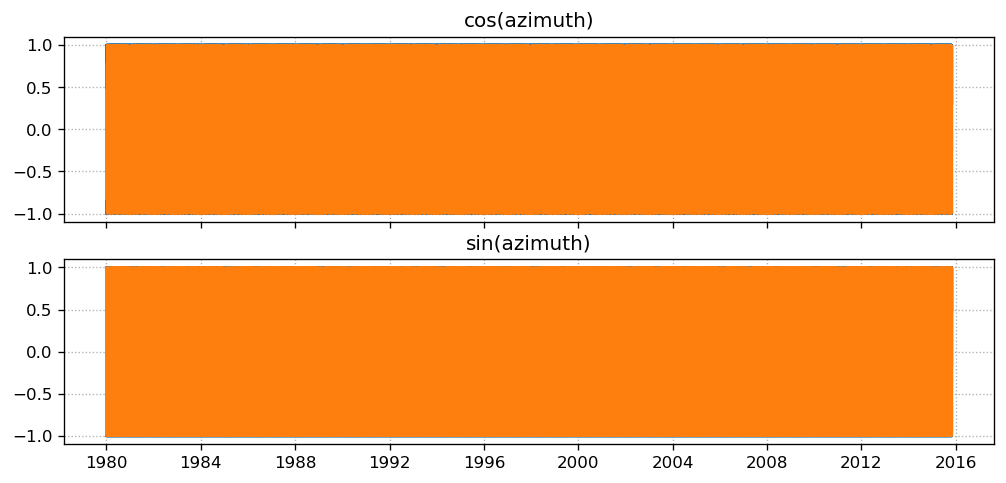

In [22]:
#
fig,ax=plt.subplots(2,1,figsize=(10,4.5),dpi=120)
#Azimuth:
ax[0].plot(times_np,np.cos(azimuth_sun_deg/180*np.pi))
ax[0].plot(time_dis+np.timedelta64(m2//2,"s"),np.cos(mean_azimuth_sun_deg2/180*np.pi))
ax[0].grid(ls=":");ax[0].set_title("cos(azimuth)");ax[0].set_xticklabels("");
#ax[0].set_xlim(np.datetime64("1998-01-01"),np.datetime64("2008-01-01"));
ax[1].plot(times_np,np.sin(azimuth_sun_deg/180*np.pi))
ax[1].plot(time_dis+np.timedelta64(m2//2,"s"),np.sin(mean_azimuth_sun_deg2/180*np.pi))
ax[1].grid(ls=":");ax[1].set_title("sin(azimuth)");

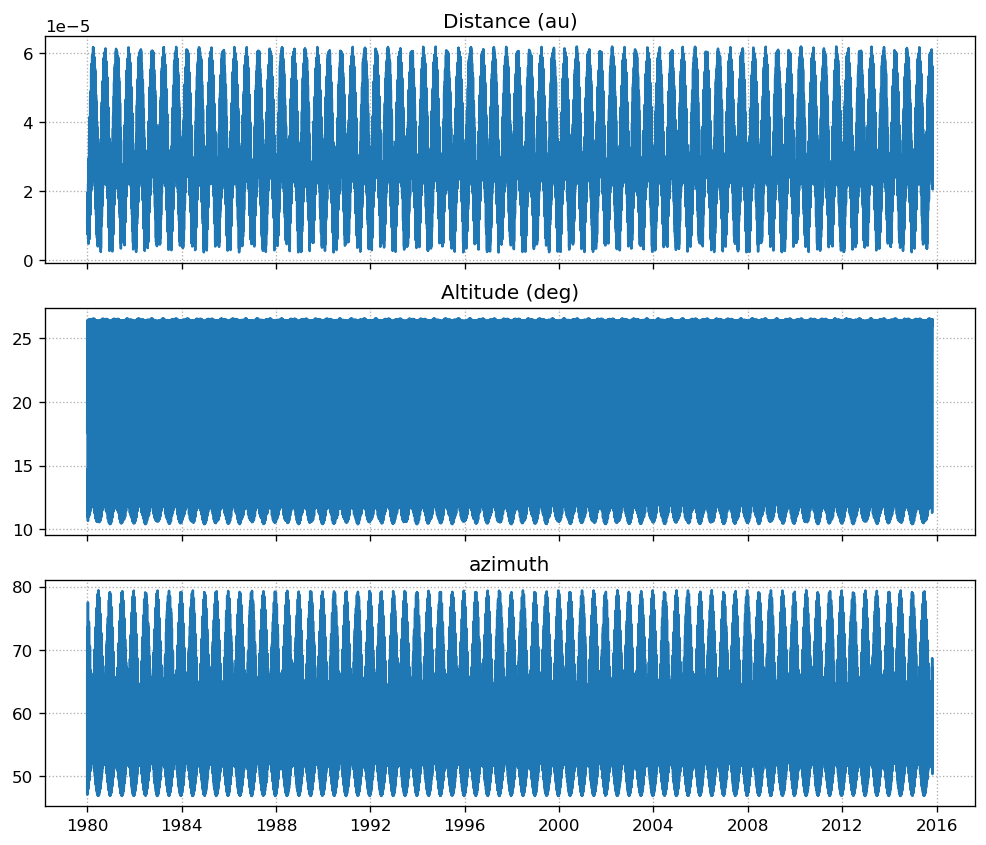

In [34]:
#std---
fig,ax=plt.subplots(3,1,figsize=(10,8.5),dpi=120)
#Distance (perigee-apogee variation):
#ax[0].plot(times_np,distance_sun_au)
ax[0].plot(time_dis+np.timedelta64(m2//2,"s"),std_distance_sun_au)
ax[0].grid(ls=":");ax[0].set_title("Distance (au)");ax[0].set_xticklabels("");
#ax[0].set_xlim(np.datetime64("1980-01-01"),np.datetime64("1996-01-01"))
#Altitude:
#ax[1].plot(times_np,altitude_sun_deg)
ax[1].plot(time_dis+np.timedelta64(m2//2,"s"),std_altitude_sun_deg)
ax[1].grid(ls=":");ax[1].set_title("Altitude (deg)");ax[1].set_xticklabels("");
#ax[1].set_xlim(np.datetime64("1980-01-01"),np.datetime64("1996-01-01"))
#Azimuth:
ax[2].plot(time_dis+np.timedelta64(m2//2,"s"),std_azimuth_sun_deg)
ax[2].grid(ls=":");ax[2].set_title("azimuth");
#ax[2].set_xlim(np.datetime64("1980-01-01"),np.datetime64("1996-01-01"));
#ax[3].plot(times_np,np.cos(azimuth_sun_deg/180*np.pi))
#ax[3].grid(ls=":");ax[3].set_title("Cos(azimuth)");

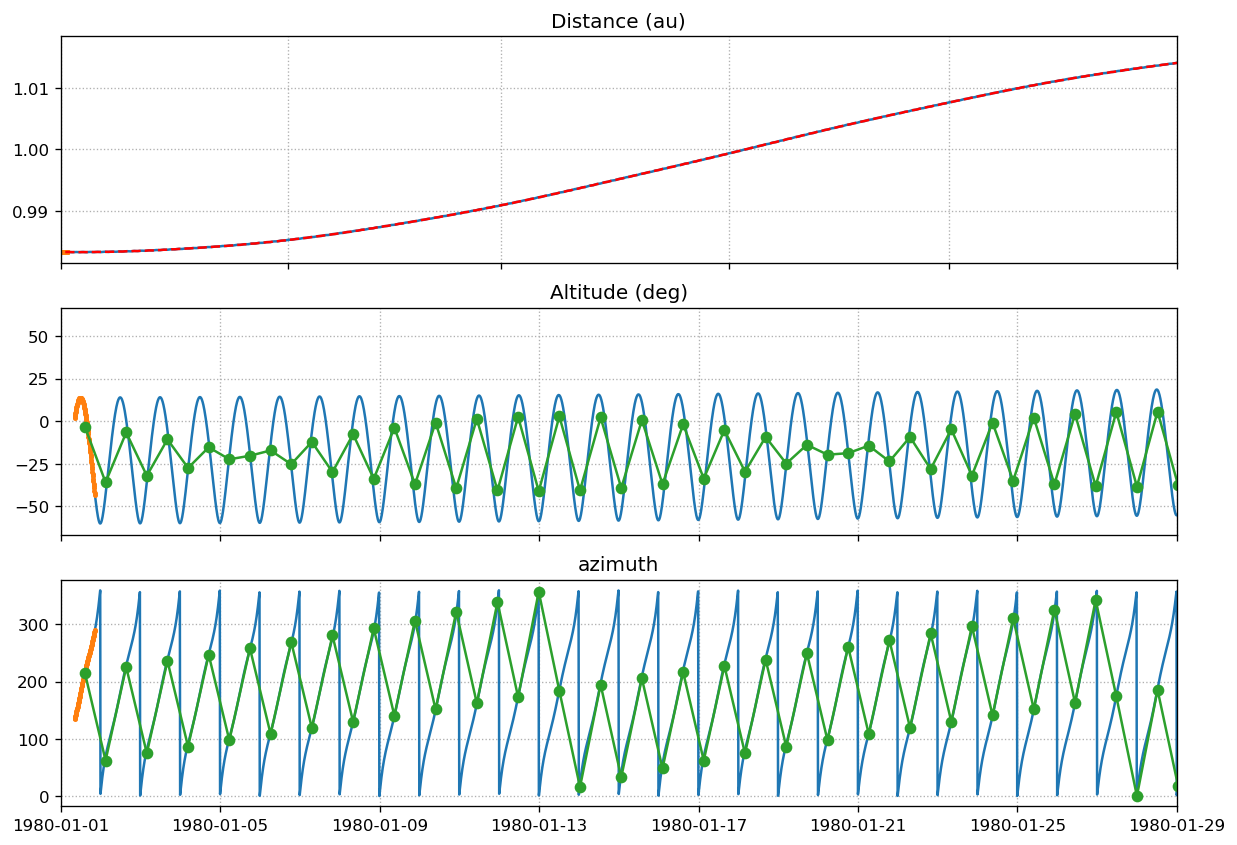

In [32]:
fig,ax=plt.subplots(3,1,figsize=(12,8.5),dpi=120)
#Distance (perigee-apogee variation):
ax[0].plot(times_np,distance_sun_au)
ax[0].plot(times_np[:nt_interval],distance_sun_au[:nt_interval],"-o",ms=2)
ax[0].plot(time_dis+np.timedelta64(m2//2,"s"),mean_distance_sun_au,'--',c='r')
ax[0].grid(ls=":");ax[0].set_title("Distance (au)");ax[0].set_xticklabels("");
ax[0].set_xlim(np.datetime64("1980-01-01"),np.datetime64("1980-06-01"))
#Altitude:
ax[1].plot(times_np,altitude_sun_deg)
ax[1].plot(times_np[:nt_interval],altitude_sun_deg[:nt_interval],"-o",ms=2)
ax[1].plot(time_dis+np.timedelta64(m2//2,"s"),mean_altitude_sun_deg,"-o")
ax[1].grid(ls=":");ax[1].set_title("Altitude (deg)");ax[1].set_xticklabels("");
ax[1].set_xlim(np.datetime64("1980-01-01"),np.datetime64("1980-01-29"))
#Azimuth:
#convert azimuth from -180:180
#azimuth_sun_deg2=azimuth_sun_deg*1.
#azimuth_sun_deg2[azimuth_sun_deg2>180]=azimuth_sun_deg2[azimuth_sun_deg2>180]-360
#ax[2].plot(times_np,azimuth_sun_deg2)
#ax[2].plot(times_np[nt_interval:nt_interval*2],azimuth_sun_deg2[nt_interval:nt_interval*2],"-o",ms=2)
#ax[2].plot(time_dis+np.timedelta64(m2//2,"s"),azimuth_sun_deg2,"-o")
#
#convert azimuth from 0:360
mean_azimuth_sun_deg2=mean_azimuth_sun_deg*1.
mean_azimuth_sun_deg2[mean_azimuth_sun_deg2<0]=mean_azimuth_sun_deg2[mean_azimuth_sun_deg2<0]+360
ax[2].plot(times_np,azimuth_sun_deg)
ax[2].plot(times_np[:nt_interval],azimuth_sun_deg[:nt_interval],"-o",ms=2)
ax[2].plot(time_dis+np.timedelta64(m2//2,"s"),mean_azimuth_sun_deg2,"-o")
ax[2].grid(ls=":");ax[2].set_title("azimuth");
ax[2].set_xlim(np.datetime64("1980-01-01"),np.datetime64("1980-01-29"));
#ax[3].plot(times_np,np.cos(azimuth_sun_deg/180*np.pi))
#ax[3].grid(ls=":");ax[3].set_title("Cos(azimuth)");

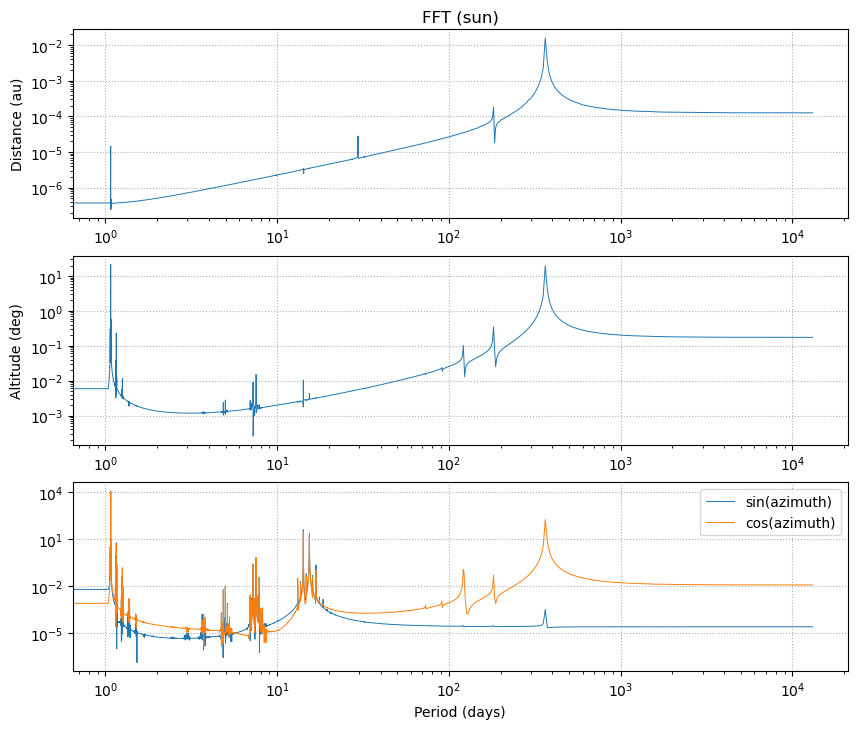

In [25]:
#FFT---
#
#so we can see that there is aliasing of the original 2xS2 signal to 2xM2 signal, when using M2-avg
#
n=len(time_dis);  #1/24 days
freq=fftt.fftfreq(n, m2/86400)[1:n//2+1]
#freq2 =np.arange(n//2+1)[1:]/(n*dtt) #the same as above
per=1/freq
fig,ax=plt.subplots(3,1,figsize=(10,8.5),dpi=100)
yf=(np.abs(fftt.fft(mean_distance_sun_au))[:n//2+1]/n)[1:] #here we are selecting half the spectra from high freq to low only, and excluding first coefficient =avg
ax[0].loglog(1/freq,2*yf,'-',ms=2,lw=.7);ax[0].grid(ls=":");ax[0].set_ylabel("Distance (au)");ax[0].set_title("FFT (sun)")
yf=(np.abs(fftt.fft(mean_altitude_sun_deg))[:n//2+1]/n)[1:]
ax[1].loglog(1/freq,2*yf,'-',ms=2,lw=.7);ax[1].grid(ls=":");ax[1].set_ylabel("Altitude (deg)")
yf=(np.abs(fftt.fft(np.sin(mean_azimuth_sun_deg/180*np.pi)))[:n//2+1]**2/n)[1:]
ax[2].loglog(1/freq,2*yf,'-',ms=2,lw=.7,label="sin(azimuth)");ax[2].grid(ls=":");ax[2].set_xlabel("Period (days)");
yf=(np.abs(fftt.fft(np.cos(mean_azimuth_sun_deg/180*np.pi)))[:n//2+1]**2/n)[1:]
ax[2].loglog(1/freq,2*yf,'-',ms=2,lw=.7,label="cos(azimuth)");ax[2].grid(ls=":");ax[2].set_xlabel("Period (days)");
ax[2].legend()

### The same as above, but starting from 21 steps ahead t0 = 21xdt = 21x566 = 3.3h

In [ ]:
#- now we can mainly see the negative trend in the azimuth
#- more contrast between sine and cos of the azimuth

In [35]:
#reshape variables---
nn=21 #start from initial value
#(nt_dep-1,nt_interval)
distance_sun_au_re2=np.reshape(distance_sun_au[nn:len(distance_sun_au)-nt_interval+nn],(nt_dep-1,nt_interval))
altitude_sun_deg_re2=np.reshape(altitude_sun_deg[nn:len(distance_sun_au)-nt_interval+nn],(nt_dep-1,nt_interval))
azimuth_sun_deg_re2=np.reshape(azimuth_sun_deg[nn:len(distance_sun_au)-nt_interval+nn],(nt_dep-1,nt_interval))
#
mean_distance_sun_au2, std_distance_sun_au2 = np.mean(distance_sun_au_re2,axis=-1), np.std(distance_sun_au_re2,axis=-1)
mean_altitude_sun_deg2, std_altitude_sun_deg2 = circ_mean_std(altitude_sun_deg_re2)
mean_azimuth_sun_deg2, std_azimuth_sun_deg2 = circ_mean_std(azimuth_sun_deg_re2)

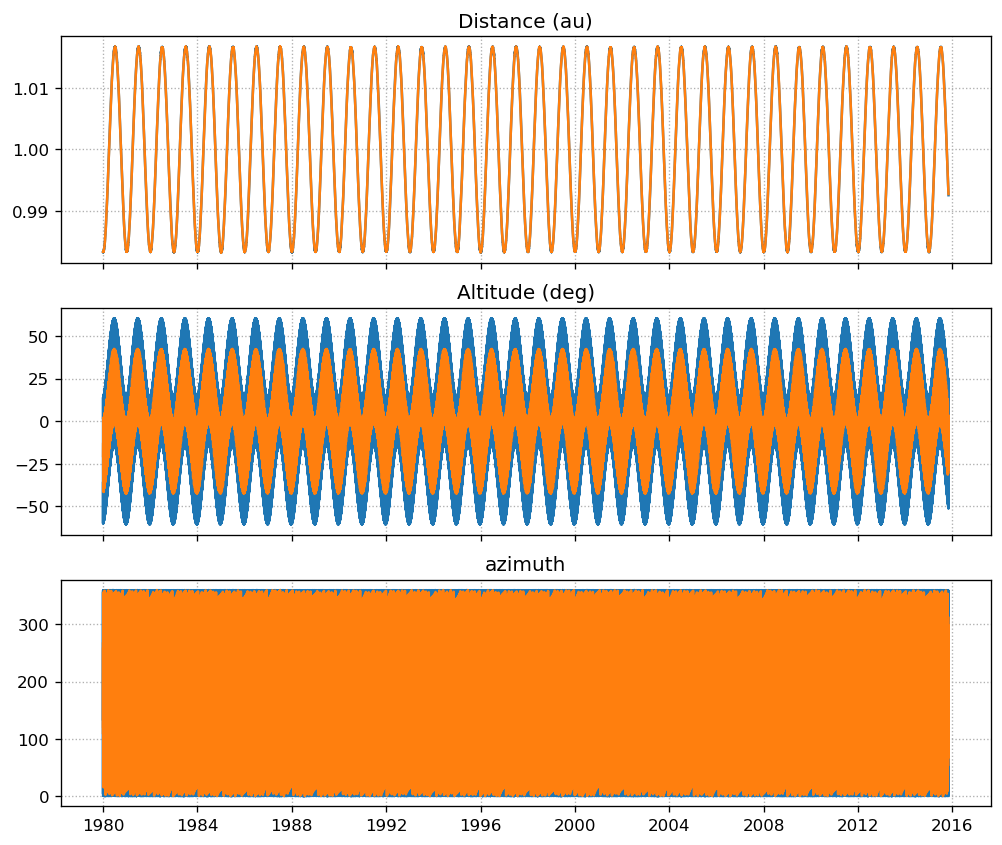

In [36]:
fig,ax=plt.subplots(3,1,figsize=(10,8.5),dpi=120)
#Distance (perigee-apogee variation):
ax[0].plot(times_np,distance_sun_au)
ax[0].plot(time_dis[:-1]+np.timedelta64(m2//2+nn*dt_fac_m2_sec,"s"),mean_distance_sun_au2)
ax[0].grid(ls=":");ax[0].set_title("Distance (au)");ax[0].set_xticklabels("");
#ax[0].set_xlim(np.datetime64("1980-01-01"),np.datetime64("1996-01-01"))
#Altitude:
ax[1].plot(times_np,altitude_sun_deg)
ax[1].plot(time_dis[:-1]+np.timedelta64(m2//2+nn*dt_fac_m2_sec,"s"),mean_altitude_sun_deg2)
ax[1].grid(ls=":");ax[1].set_title("Altitude (deg)");ax[1].set_xticklabels("");
#ax[1].set_xlim(np.datetime64("1980-01-01"),np.datetime64("1996-01-01"))
#Azimuth:
mean_azimuth_sun_deg2b=mean_azimuth_sun_deg2*1.
mean_azimuth_sun_deg2b[mean_azimuth_sun_deg2b<0]=mean_azimuth_sun_deg2b[mean_azimuth_sun_deg2b<0]+360
ax[2].plot(times_np,azimuth_sun_deg)
ax[2].plot(time_dis[:-1]+np.timedelta64(m2//2+nn*dt_fac_m2_sec,"s"),mean_azimuth_sun_deg2b)
ax[2].grid(ls=":");ax[2].set_title("azimuth");
#ax[2].set_xlim(np.datetime64("1980-01-01"),np.datetime64("1996-01-01"));
#ax[3].plot(times_np,np.cos(azimuth_sun_deg/180*np.pi))
#ax[3].grid(ls=":");ax[3].set_title("Cos(azimuth)");

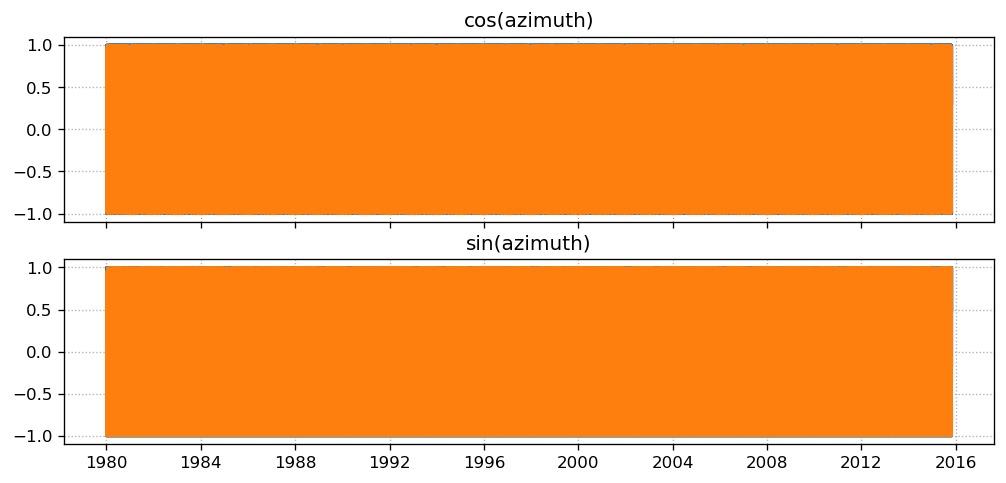

In [37]:
#
fig,ax=plt.subplots(2,1,figsize=(10,4.5),dpi=120)
#Azimuth:
ax[0].plot(times_np,np.cos(azimuth_sun_deg/180*np.pi))
ax[0].plot(time_dis[:-1]+np.timedelta64(m2//2+nn,"s"),np.cos(mean_azimuth_sun_deg2b/180*np.pi))
ax[0].grid(ls=":");ax[0].set_title("cos(azimuth)");ax[0].set_xticklabels("");
#ax[0].set_xlim(np.datetime64("1998-01-01"),np.datetime64("2008-01-01"));
ax[1].plot(times_np,np.sin(azimuth_sun_deg/180*np.pi))
ax[1].plot(time_dis[:-1]+np.timedelta64(m2//2+nn,"s"),np.sin(mean_azimuth_sun_deg2b/180*np.pi))
ax[1].grid(ls=":");ax[1].set_title("sin(azimuth)");

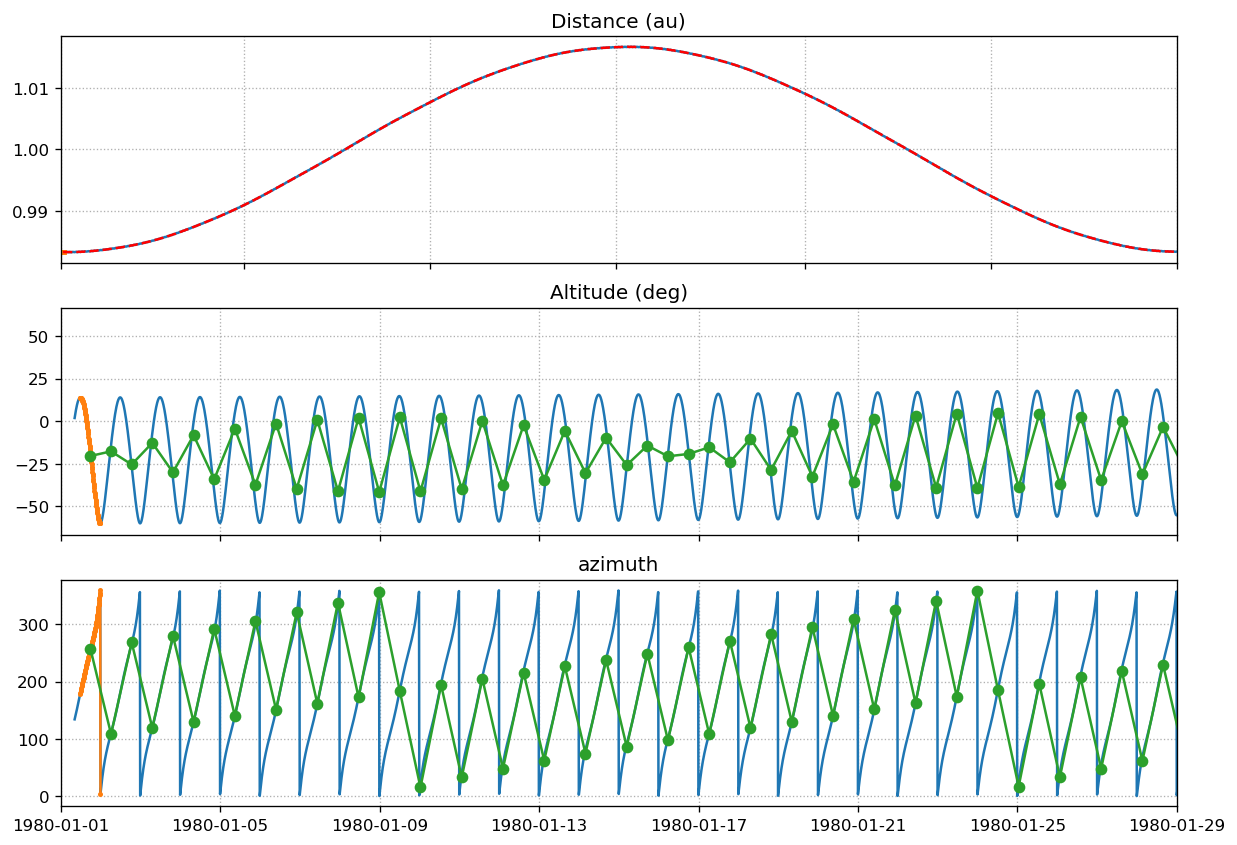

In [39]:
fig,ax=plt.subplots(3,1,figsize=(12,8.5),dpi=120)
#Distance (perigee-apogee variation):
ax[0].plot(times_np,distance_sun_au)
ax[0].plot(times_np[nn:nt_interval+nn],distance_sun_au[nn:nt_interval+nn],"-o",ms=2)
ax[0].plot(time_dis[:-1]+np.timedelta64(m2//2+nn*dt_fac_m2_sec,"s"),mean_distance_sun_au2,'--',c='r')
ax[0].grid(ls=":");ax[0].set_title("Distance (au)");ax[0].set_xticklabels("");
ax[0].set_xlim(np.datetime64("1980-01-01"),np.datetime64("1981-01-01"))
#Altitude:
ax[1].plot(times_np,altitude_sun_deg)
ax[1].plot(times_np[nn:nt_interval+nn],altitude_sun_deg[nn:nt_interval+nn],"-o",ms=2)
ax[1].plot(time_dis[:-1]+np.timedelta64(m2//2+nn*dt_fac_m2_sec,"s"),mean_altitude_sun_deg2,"-o")
ax[1].grid(ls=":");ax[1].set_title("Altitude (deg)");ax[1].set_xticklabels("");
ax[1].set_xlim(np.datetime64("1980-01-01"),np.datetime64("1980-01-29"))
#Azimuth:
ax[2].plot(times_np,azimuth_sun_deg)
ax[2].plot(times_np[nn:nt_interval+nn],azimuth_sun_deg[nn:nt_interval+nn],"-o",ms=2)
ax[2].plot(time_dis[:-1]+np.timedelta64(m2//2+nn*dt_fac_m2_sec,"s"),mean_azimuth_sun_deg2b,"-o")
ax[2].grid(ls=":");ax[2].set_title("azimuth");
ax[2].set_xlim(np.datetime64("1980-01-01"),np.datetime64("1980-01-29"));
#ax[3].plot(times_np,np.cos(azimuth_sun_deg/180*np.pi))
#ax[3].grid(ls=":");ax[3].set_title("Cos(azimuth)");

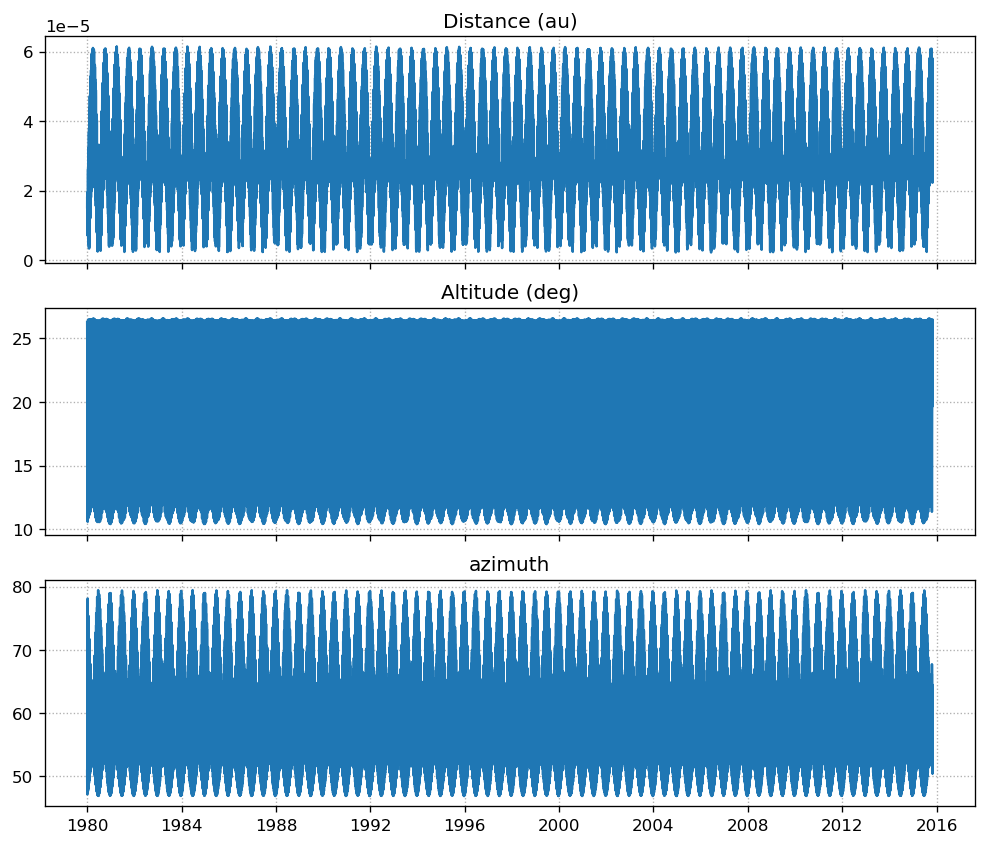

In [40]:
fig,ax=plt.subplots(3,1,figsize=(10,8.5),dpi=120)
#Distance (perigee-apogee variation):
#ax[0].plot(times_np,distance_sun_au)
ax[0].plot(time_dis[:-1]+np.timedelta64(m2//2+nn,"s"),std_distance_sun_au2)
ax[0].grid(ls=":");ax[0].set_title("Distance (au)");ax[0].set_xticklabels("");
#ax[0].set_xlim(np.datetime64("1980-01-01"),np.datetime64("1996-01-01"))
#Altitude:
#ax[1].plot(times_np,altitude_sun_deg)
ax[1].plot(time_dis[:-1]+np.timedelta64(m2//2+nn,"s"),std_altitude_sun_deg2)
ax[1].grid(ls=":");ax[1].set_title("Altitude (deg)");ax[1].set_xticklabels("");
#ax[1].set_xlim(np.datetime64("1980-01-01"),np.datetime64("1996-01-01"))
#Azimuth:
ax[2].plot(time_dis[:-1]+np.timedelta64(m2//2+nn,"s"),std_azimuth_sun_deg2)
ax[2].grid(ls=":");ax[2].set_title("azimuth");
#ax[2].set_xlim(np.datetime64("1980-01-01"),np.datetime64("1996-01-01"));
#ax[3].plot(times_np,np.cos(azimuth_sun_deg/180*np.pi))
#ax[3].grid(ls=":");ax[3].set_title("Cos(azimuth)");

### Taking values every M2

In [ ]:
#we can see that if we just take values every M2, we get the same behaviour as the original M2-avg:
#a not clear 18.6y cycle for altitude, a negative trend for mean azimuth, and partly remove the effect of m2 because signals have 2xm2 periodicity

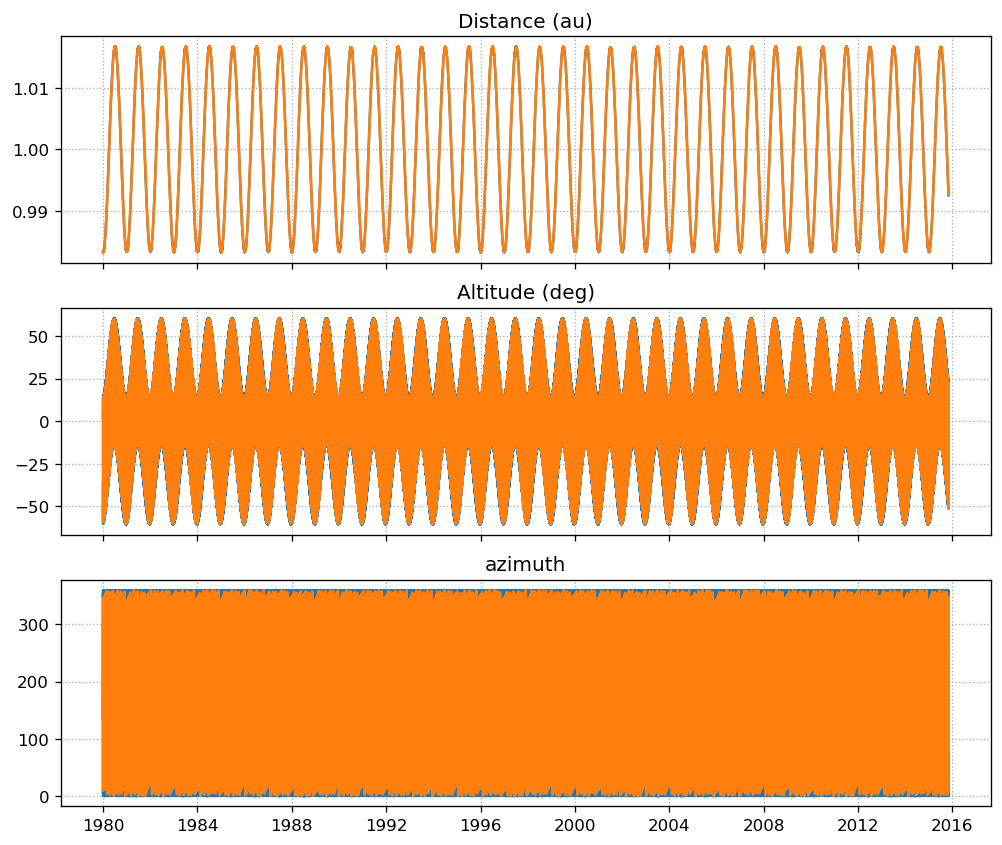

In [41]:
fig,ax=plt.subplots(3,1,figsize=(10,8.5),dpi=120)
#Distance (perigee-apogee variation):
ax[0].plot(times_np,distance_sun_au)
ax[0].plot(times_np[::nt_interval],distance_sun_au[::nt_interval])
ax[0].grid(ls=":");ax[0].set_title("Distance (au)");ax[0].set_xticklabels("");
#ax[0].set_xlim(np.datetime64("1980-01-01"),np.datetime64("1996-01-01"))
#Altitude:
ax[1].plot(times_np,altitude_sun_deg)
ax[1].plot(times_np[::nt_interval],altitude_sun_deg[::nt_interval])
ax[1].grid(ls=":");ax[1].set_title("Altitude (deg)");ax[1].set_xticklabels("");
#ax[1].set_xlim(np.datetime64("1980-01-01"),np.datetime64("1996-01-01"))
#Azimuth:
ax[2].plot(times_np,azimuth_sun_deg)
ax[2].plot(times_np[::nt_interval],azimuth_sun_deg[::nt_interval])
ax[2].grid(ls=":");ax[2].set_title("azimuth");
#ax[2].set_xlim(np.datetime64("1980-01-01"),np.datetime64("1996-01-01"));
#ax[3].plot(times_np,np.cos(azimuth_sun_deg/180*np.pi))
#ax[3].grid(ls=":");ax[3].set_title("Cos(azimuth)");

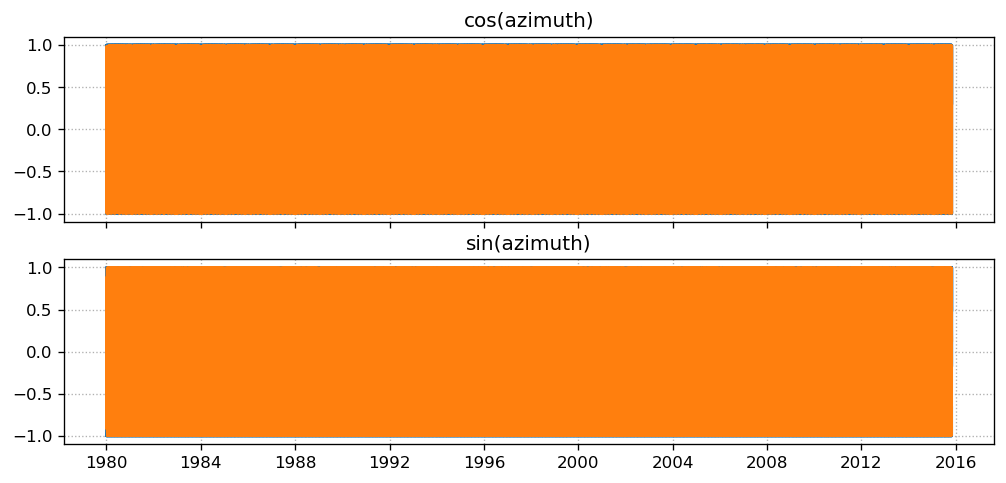

In [42]:
#
fig,ax=plt.subplots(2,1,figsize=(10,4.5),dpi=120)
#Azimuth:
ax[0].plot(times_np,np.cos(azimuth_sun_deg/180*np.pi))
ax[0].plot(times_np[::nt_interval],np.cos(azimuth_sun_deg[::nt_interval]/180*np.pi))
ax[0].grid(ls=":");ax[0].set_title("cos(azimuth)");ax[0].set_xticklabels("");
#ax[0].set_xlim(np.datetime64("1998-01-01"),np.datetime64("2008-01-01"));
ax[1].plot(times_np,np.sin(azimuth_sun_deg/180*np.pi))
ax[1].plot(times_np[::nt_interval],np.sin(azimuth_sun_deg[::nt_interval]/180*np.pi))
ax[1].grid(ls=":");ax[1].set_title("sin(azimuth)");

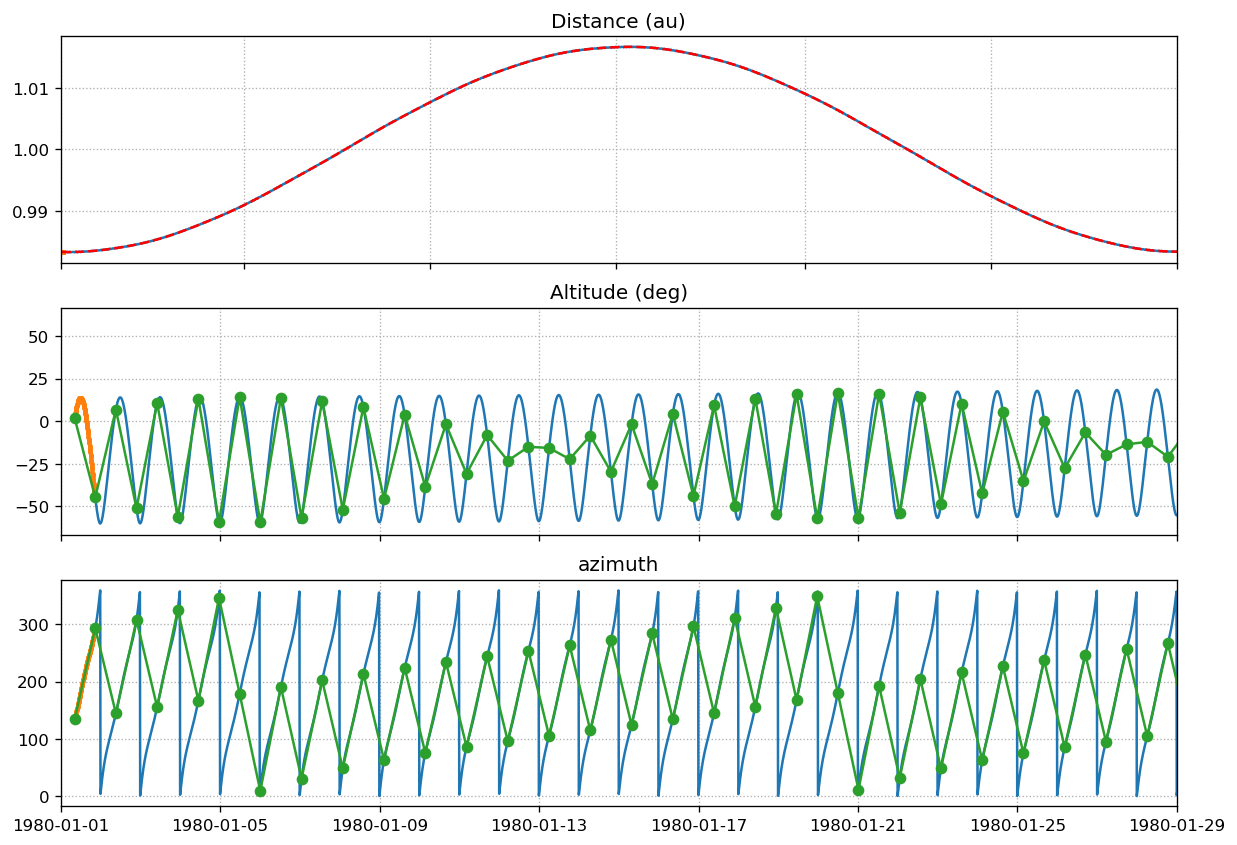

In [47]:
fig,ax=plt.subplots(3,1,figsize=(12,8.5),dpi=120)
#Distance (perigee-apogee variation):
ax[0].plot(times_np,distance_sun_au)
ax[0].plot(times_np[:nt_interval],distance_sun_au[:nt_interval],"-o",ms=2)
ax[0].plot(times_np[::nt_interval],distance_sun_au[::nt_interval],"--",c='r')
ax[0].grid(ls=":");ax[0].set_title("Distance (au)");ax[0].set_xticklabels("");
ax[0].set_xlim(np.datetime64("1980-01-01"),np.datetime64("1981-01-01"))
#Altitude:
ax[1].plot(times_np,altitude_sun_deg)
ax[1].plot(times_np[:nt_interval],altitude_sun_deg[:nt_interval],"-o",ms=2)
ax[1].plot(times_np[::nt_interval],altitude_sun_deg[::nt_interval],"-o")
ax[1].grid(ls=":");ax[1].set_title("Altitude (deg)");ax[1].set_xticklabels("");
ax[1].set_xlim(np.datetime64("1980-01-01"),np.datetime64("1980-01-29"))
#Azimuth:
ax[2].plot(times_np,azimuth_sun_deg)
ax[2].plot(times_np[:nt_interval],azimuth_sun_deg[:nt_interval],"-o",ms=2)
ax[2].plot(times_np[::nt_interval],azimuth_sun_deg[::nt_interval],"-o")
ax[2].grid(ls=":");ax[2].set_title("azimuth");
ax[2].set_xlim(np.datetime64("1980-01-01"),np.datetime64("1980-01-29"));
#ax[3].plot(times_np,np.cos(azimuth_sun_deg/180*np.pi))
#ax[3].grid(ls=":");ax[3].set_title("Cos(azimuth)");

### using data every s2

In [48]:
#create a time vector with skyfield--- 
s2=12.0*3600

#find total seconds between init and final date:
ti=datetime.datetime(tinip.year,tinip.month,tinip.day,tinip.hour,tinip.minute,tinip.second)
te=datetime.datetime(tendp.year,tendp.month,tendp.day,tendp.hour,tendp.minute,tendp.second)
tot_sec=(te-ti).total_seconds() #total elapsed seconds
#
#build Time objects from an UTC calendar date, using the init UTC date and the elapsed seconds since this initial date
times2=ts.utc(tinip.year,tinip.month,tinip.day,tinip.hour,tinip.minute,np.arange(tinip.second,tot_sec+1e-5,s2))
dtt=np.diff(times.tt) #=dt=9.43min
print(s2,dtt.min()*86400,dtt.mean()*86400,dtt.max()*86400,times.shape)
#
print(tinip,times2[[0,1]].utc_strftime('%Y-%m-%d %H:%M:%S'))
print(tendp,times2[[-2,-1]].utc_strftime('%Y-%m-%d %H:%M:%S'))
np.sum(np.diff(times.tt))*86400,(times[-1].tt-times[0].tt)*86400,s2*(len(times)-1)

#using numpy (it does not take into account leap seconds), but the size of the array is the same as skyfield
#the elapsed time is also the same
times_np2=np.arange(tini,tend+np.timedelta64(1,'s'),int(s2*1e9),dtype='datetime64[ns]') 
print(times_np2,times_np2.shape)

43200.0 565.9999877214432 565.9999999999953 566.0000279545784 (1997910,)
1980-01-01 08:20:00 ['1980-01-01 08:20:00', '1980-01-01 20:20:00']
2015-11-01 12:01:34 ['2015-10-31 20:19:43', '2015-11-01 08:19:43']
['1980-01-01T08:20:00.000000000' '1980-01-01T20:20:00.000000000'
 '1980-01-02T08:20:00.000000000' ... '2015-10-31T08:20:00.000000000'
 '2015-10-31T20:20:00.000000000' '2015-11-01T08:20:00.000000000'] (26177,)


In [50]:
%%time
#MOON----
astro_sun = dws.at(times2).observe(sun)
alt_sun2, az_sun2, dist_sun2 = astro_sun.apparent().altaz()
print(alt_sun2)
print(az_sun2)
#print(dist_sun)
#
#convert above values to arrays---
#altitude_sun_rad=alt_sun.radians
altitude_sun_deg2=alt_sun2.degrees
#azimuth_sun_rad=alt_sun.radians
azimuth_sun_deg2=az_sun2.degrees
distance_sun_au2 = dist_sun2.au #AU units
#distance_sun_km = dist_sun.km #km units
#distance_sun_km2 = dist_sun2.km #km units
#a=distance_sun_km-distance_sun_km2 #almost the same distnace when using .radec
print(altitude_sun_deg2[[0,-1]])
print(azimuth_sun_deg2[[0,-1]])
print(distance_sun_au2[[0,-1]])
#print(distance_sun_km[[0,-1]])

26177 values from 01deg 54' 53.1" to 11deg 44' 11.6"
26177 values from 134deg 04' 23.5" to 134deg 09' 52.1"
[ 1.9147423  11.73656824]
[134.07320716 134.16446303]
[0.98327023 0.99258315]
CPU times: user 29.4 s, sys: 1.19 s, total: 30.6 s
Wall time: 2.53 s


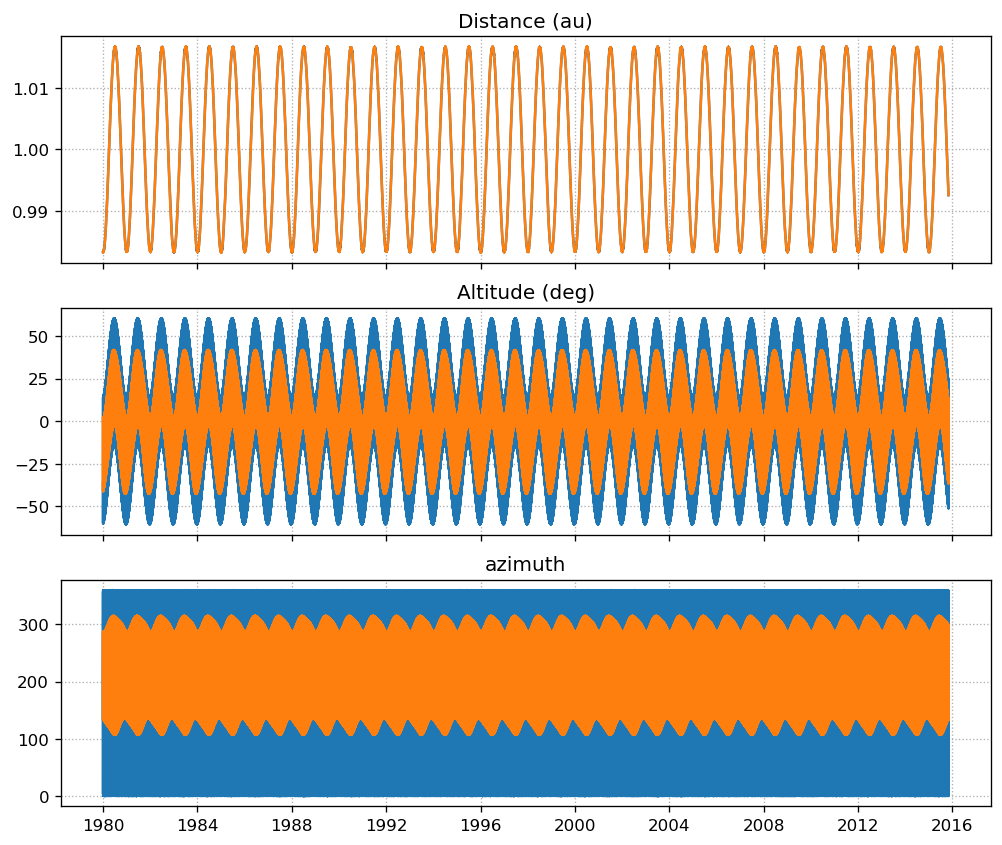

In [51]:
fig,ax=plt.subplots(3,1,figsize=(10,8.5),dpi=120)
#Distance (perigee-apogee variation):
ax[0].plot(times_np,distance_sun_au)
ax[0].plot(times_np2,distance_sun_au2)
ax[0].grid(ls=":");ax[0].set_title("Distance (au)");ax[0].set_xticklabels("");
#ax[0].set_xlim(np.datetime64("1980-01-01"),np.datetime64("1996-01-01"))
#Altitude:
ax[1].plot(times_np,altitude_sun_deg)
ax[1].plot(times_np2,altitude_sun_deg2)
ax[1].grid(ls=":");ax[1].set_title("Altitude (deg)");ax[1].set_xticklabels("");
#ax[1].set_xlim(np.datetime64("1980-01-01"),np.datetime64("1996-01-01"))
#Azimuth:
#convert azimuth from -180:180
#azimuth_sun_deg2=azimuth_sun_deg*1.
#azimuth_sun_deg2[azimuth_sun_deg2>180]=azimuth_sun_deg2[azimuth_sun_deg2>180]-360
#ax[2].plot(times_np,azimuth_sun_deg2)
#ax[2].plot(times_np[nt_interval:nt_interval*2],azimuth_sun_deg2[nt_interval:nt_interval*2],"-o",ms=2)
#ax[2].plot(time_dis+np.timedelta64(m2//2,"s"),azimuth_sun_deg2,"-o")
#
#convert azimuth from 0:360
ax[2].plot(times_np,azimuth_sun_deg)
ax[2].plot(times_np2,azimuth_sun_deg2)
ax[2].grid(ls=":");ax[2].set_title("azimuth");
#ax[2].set_xlim(np.datetime64("1980-01-01"),np.datetime64("1996-01-01"));
#ax[3].plot(times_np,np.cos(azimuth_sun_deg/180*np.pi))
#ax[3].grid(ls=":");ax[3].set_title("Cos(azimuth)");

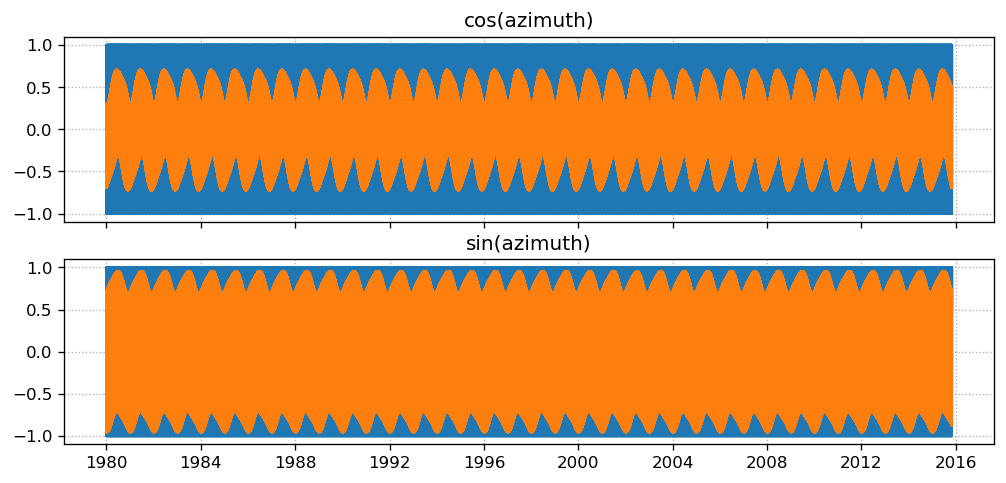

In [52]:
#
fig,ax=plt.subplots(2,1,figsize=(10,4.5),dpi=120)
#Azimuth:
ax[0].plot(times_np,np.cos(azimuth_sun_deg/180*np.pi))
ax[0].plot(times_np2,np.cos(azimuth_sun_deg2/180*np.pi))
ax[0].grid(ls=":");ax[0].set_title("cos(azimuth)");ax[0].set_xticklabels("");
#ax[0].set_xlim(np.datetime64("1998-01-01"),np.datetime64("2008-01-01"));
ax[1].plot(times_np,np.sin(azimuth_sun_deg/180*np.pi))
ax[1].plot(times_np2,np.sin(azimuth_sun_deg2/180*np.pi))
ax[1].grid(ls=":");ax[1].set_title("sin(azimuth)");

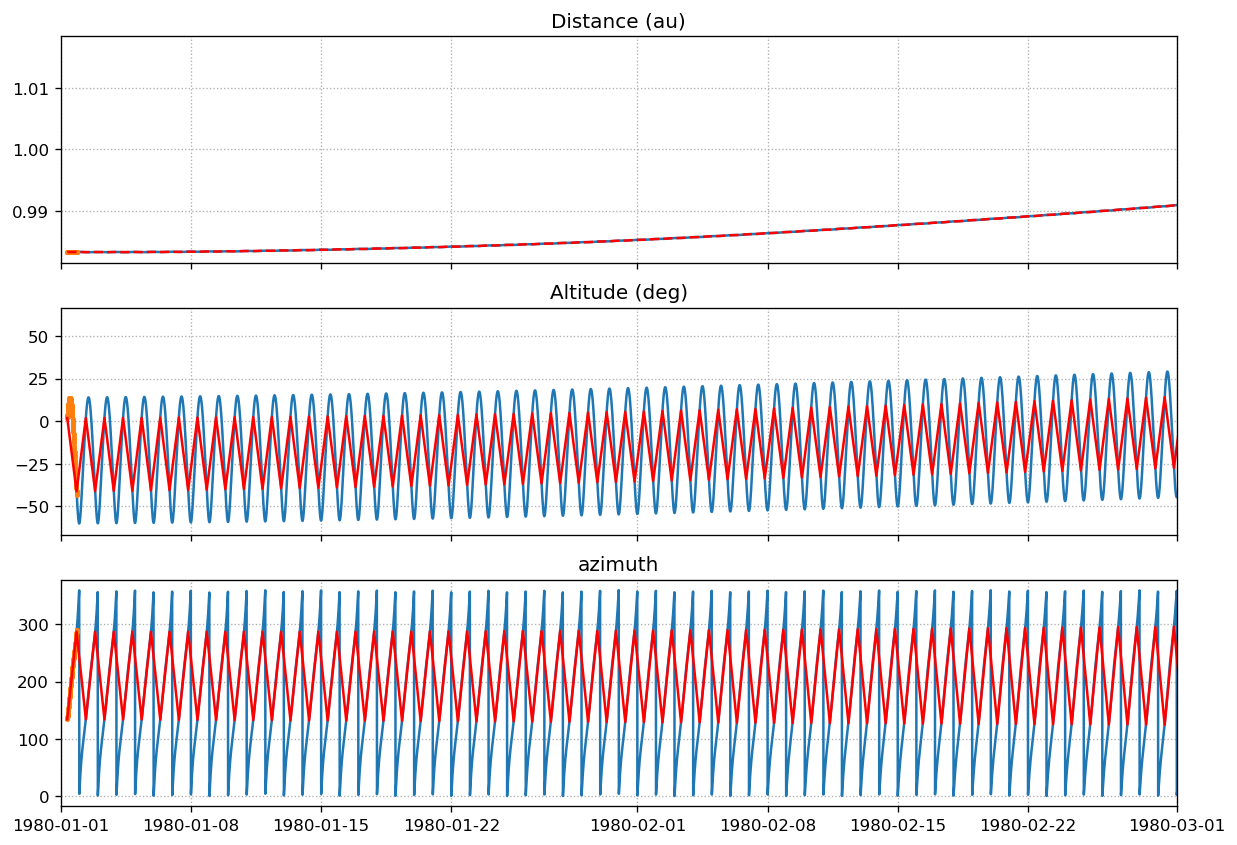

In [61]:
fig,ax=plt.subplots(3,1,figsize=(12,8.5),dpi=120)
#Distance (perigee-apogee variation):
ax[0].plot(times_np,distance_sun_au)
ax[0].plot(times_np[:nt_interval],distance_sun_au[:nt_interval],"-o",ms=2)
ax[0].plot(times_np2,distance_sun_au2,"--",c="r")
ax[0].grid(ls=":");ax[0].set_title("Distance (au)");ax[0].set_xticklabels("");
ax[0].set_xlim(np.datetime64("1980-01-01"),np.datetime64("1980-03-01"))
#Altitude:
ax[1].plot(times_np,altitude_sun_deg)
ax[1].plot(times_np[:nt_interval],altitude_sun_deg[:nt_interval],"-o",ms=2)
ax[1].plot(times_np2,altitude_sun_deg2,"-",c="r")
ax[1].grid(ls=":");ax[1].set_title("Altitude (deg)");ax[1].set_xticklabels("");
ax[1].set_xlim(np.datetime64("1980-01-01"),np.datetime64("1980-03-01"))
#Azimuth:
ax[2].plot(times_np,azimuth_sun_deg)
ax[2].plot(times_np[:nt_interval],azimuth_sun_deg[:nt_interval],"-o",ms=2)
ax[2].plot(times_np2,azimuth_sun_deg2,"-",c="r")
ax[2].grid(ls=":");ax[2].set_title("azimuth");
ax[2].set_xlim(np.datetime64("1980-01-01"),np.datetime64("1980-03-01"));
#ax[3].plot(times_np,np.cos(azimuth_sun_deg/180*np.pi))
#ax[3].grid(ls=":");ax[3].set_title("Cos(azimuth)");

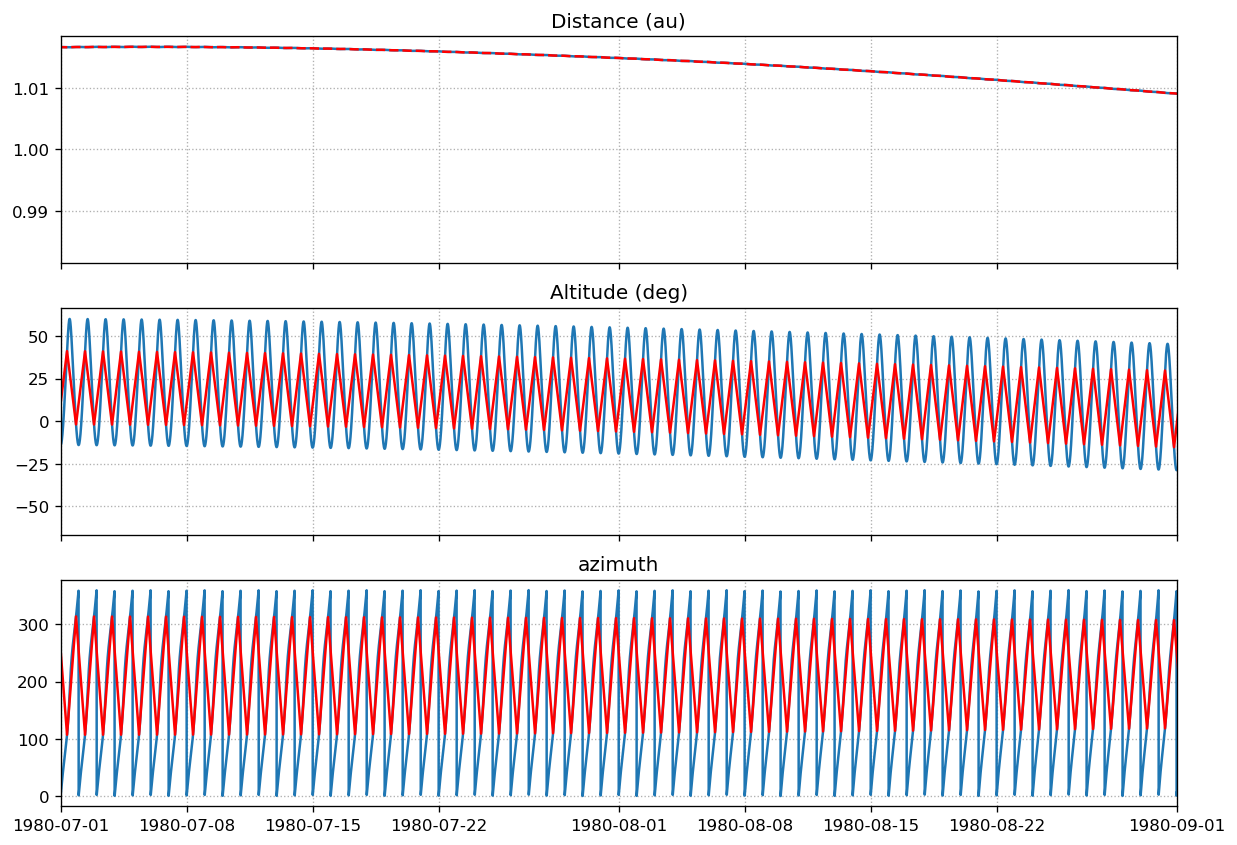

In [63]:
fig,ax=plt.subplots(3,1,figsize=(12,8.5),dpi=120)
#Distance (perigee-apogee variation):
ax[0].plot(times_np,distance_sun_au)
ax[0].plot(times_np[:nt_interval],distance_sun_au[:nt_interval],"-o",ms=2)
ax[0].plot(times_np2,distance_sun_au2,"--",c="r")
ax[0].grid(ls=":");ax[0].set_title("Distance (au)");ax[0].set_xticklabels("");
ax[0].set_xlim(np.datetime64("1980-07-01"),np.datetime64("1980-09-01"))
#Altitude:
ax[1].plot(times_np,altitude_sun_deg)
ax[1].plot(times_np[:nt_interval],altitude_sun_deg[:nt_interval],"-o",ms=2)
ax[1].plot(times_np2,altitude_sun_deg2,"-",c="r")
ax[1].grid(ls=":");ax[1].set_title("Altitude (deg)");ax[1].set_xticklabels("");
ax[1].set_xlim(np.datetime64("1980-07-01"),np.datetime64("1980-09-01"))
#Azimuth:
ax[2].plot(times_np,azimuth_sun_deg)
ax[2].plot(times_np[:nt_interval],azimuth_sun_deg[:nt_interval],"-o",ms=2)
ax[2].plot(times_np2,azimuth_sun_deg2,"-",c="r")
ax[2].grid(ls=":");ax[2].set_title("azimuth");
ax[2].set_xlim(np.datetime64("1980-07-01"),np.datetime64("1980-09-01"));
#ax[3].plot(times_np,np.cos(azimuth_sun_deg/180*np.pi))
#ax[3].grid(ls=":");ax[3].set_title("Cos(azimuth)");